# MO-444 / Trabalho 2 - Regressão Logística e Redes Neurais



Código referência:
    https://extrapolations.dev/blog/2013/07/basic-neural-network-python/

In [5]:

from PIL import Image
import math
import time as texec
from datetime import datetime

from sklearn.model_selection import train_test_split
from skimage import exposure
from sklearn.metrics import confusion_matrix

import matplotlib.image as mpimg
import matplotlib.pyplot as plt

import numpy as np

import tensorflow as tf
from scipy import optimize
from scipy.optimize import minimize, rosen, rosen_der, rosen_hess

import pandas as pd

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

from IPython.core.debugger import set_trace

from keras import layers
from keras.models import Model
from keras.models import load_model
from keras import callbacks
from keras.utils import np_utils


In [6]:

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
#
# Leitura dos Dados
#
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

from keras.datasets import cifar10

(train_features, train_labels), (test_features, test_labels) = cifar10.load_data()
num_train, img_channels, img_rows, img_cols =  train_features.shape
num_test, _, _, _ =  test_features.shape
num_classes = len(np.unique(train_labels))


In [7]:
train_features = train_features.astype('float32')/255
test_features = test_features.astype('float32')/255
# convert class labels to binary class labels
train_labels = np_utils.to_categorical(train_labels, num_classes)
test_labels = np_utils.to_categorical(test_labels, num_classes)

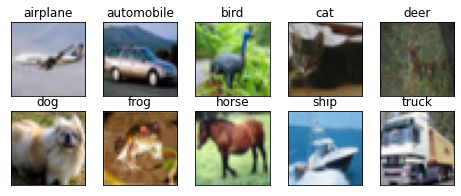

In [19]:

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
#
# Visualização das Imagens
#
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
class_names = ['airplane','automobile','bird','cat','deer','dog','frog','horse','ship','truck']
sample_index = [264,4,6,9,10,40,0,7,8,1]
fig = plt.figure(figsize=(8,3))
for i in range(num_classes):    
    ax = fig.add_subplot(2, 5, 1 + i, xticks=[], yticks=[])
    im = train_features[sample_index[i],::]
    ax.set_title(class_names[i])
    plt.imshow(im)
    
plt.show()

In [26]:
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
#
# Pré-Processamento / Tratamento dos dados
#
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

# Níveis de Cinza
# Média Ponderada: 0.3R + 0.59G + 0.11B
dados_amostras = train_features;
nro_imagens = dados_amostras.shape[0]
print("Número de imagens: %d" % nro_imagens)

dados_amostras_cinza = np.zeros((nro_imagens, 32,32), dtype=np.float)

for i in range (0, nro_imagens):    
    for j in range (0, 32):       
        for k in range (0, 32):       
                
            dados_amostras_cinza[i][j][k] = (0.3 * dados_amostras[i][j][k][0]) + (0.59 * dados_amostras[i][j][k][1]) + (0.11 * dados_amostras[i][j][k][2])

amostra_imagem = dados_amostras_cinza[indice_imagem,:]
amostra_imagem.shape = (32,32)  
imgplot = plt.imshow(amostra_imagem, interpolation='spline36', cmap='gray')
plt.axis('off')
plt.show()


Número de imagens: 50000


NameError: name 'indice_imagem' is not defined

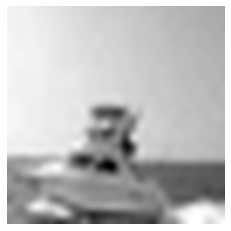

In [28]:
indice_imagem = 100
amostra_imagem = dados_amostras_cinza[indice_imagem,:]
amostra_imagem.shape = (32,32)  
imgplot = plt.imshow(amostra_imagem, interpolation='spline36', cmap='gray')
plt.axis('off')
plt.show()


In [29]:
print(dados_amostras_cinza.shape)

(50000, 32, 32)


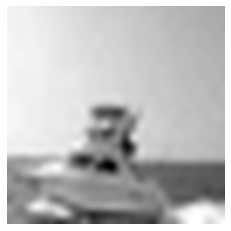

In [30]:

# Normalização -> pixel/255

dados_amostras_norm = dados_amostras_cinza / 255;

amostra_imagem = dados_amostras_norm[indice_imagem]
amostra_imagem.shape = (32,32)
imgplot = plt.imshow(amostra_imagem, interpolation='spline36', cmap='gray')
plt.axis('off')
plt.show()

In [32]:
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
#
# Divisão dos Dados
#
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

data_train_features, data_valid, data_train_target, data_valid_target = train_test_split(dados_amostras_norm, train_labels, test_size=0.2, random_state=1)

print(data_train_features.shape, data_valid.shape, data_train_target.shape, data_valid_target.shape)


(40000, 32, 32) (10000, 32, 32) (40000, 10) (10000, 10)




** REDE NEURAL **


Sigmóide: $y = \frac{1}{1 + e^{-x}}$

Derivada: $y' = \frac{e^{-x}}{(1 + e^{-x}){^2}}$

Função Custo: 


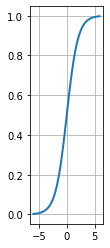

In [33]:
# Plotar as funções sigmóide

def sigmoid(z):
        return 1 / (1 + np.exp(-z))

fig = plt.figure()

testInput = np.arange(-6, 6, 0.1)
a=fig.add_subplot(1,4,3)
plt.plot(testInput, sigmoid(testInput), linewidth= 2)
plt.grid(1)

plt.show()



Entendendo uma RN

Um RN neural pode ser entendida como uma multiplicação de matriz. O Código a seguir faz uso dessa característica para realizar o foward da RN.

A playlist a seguir ajuda nessa explicação:

https://www.youtube.com/playlist?list=PLiaHhY2iBX9hdHaRr6b7XevZtgZRa1PoU

In [46]:
# Uma dimensão para o bias
img_shape = (32, 32, 1)
def create_net():

    # Camada de entrada
    img = layers.Input(shape=img_shape) 
    
    # Segunda camada - convolução com relu, podemos experimentar com sigma
    conv1 = layers.Conv2D(16, (3, 3), padding='same', activation='relu')(img)    
    mp1 = layers.MaxPooling2D(padding='same')(conv1)  # 100x25
    
    # Terceira camada - convolução com relu, podemos experimentar com sigma
    conv2 = layers.Conv2D(32, (3, 3), padding='same', activation='relu')(mp1)
    mp2 = layers.MaxPooling2D(padding='same')(conv2)  # 50x13
    
    # Quarta camada - convolução com relu, podemos experimentar com sigma
    conv3 = layers.Conv2D(32, (3, 3), padding='same', activation='relu')(mp2)
    bn = layers.BatchNormalization()(conv3)
    
    # Camada de saída
    mp3 = layers.MaxPooling2D(padding='same')(bn)  # 25x7    
    flat = layers.Flatten()(mp3)
    
    outs = layers.Dense(10, activation='relu')(flat)
    
    #model.add(Dense(num_classes, activation='softmax'))
    #outs = []
    #for _ in range(5):
    #    dens1 = layers.Dense(64, activation='relu')(flat)
    #    drop = layers.Dropout(0.5)(dens1)
    #    res = layers.Dense(1, activation='sigmoid')(drop)

    #    outs.append(res)
    
    model = Model(img, outs)
    model.compile('rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])
    model.summary()
    return model



#model.add(Dense(num_classes, activation='softmax'))
# Compile the model
#model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
# Train the model
#start = time.time()


In [47]:
def predict(filepath):
    
    img = cv2.imread(filepath, cv2.IMREAD_GRAYSCALE) / 255.
    res = np.array(net.predict(img[np.newaxis, :, :, np.newaxis]))
    ans = np.reshape(res, (5, 36))
    l_ind = []
    probs = []
    
    for a in ans:
        l_ind.append(np.argmax(a))
        probs.append(np.max(a))

    capt = ''
    for l in l_ind:
        capt += symbols[l]
    return capt, sum(probs) / 5

In [48]:
img_shape = (32, 32, 1)

#Dados
X_train = data_train_features#[:100,:]
y_train = train_labels#[:100]
    
#X_valid = data_valid
#y_valid = data_valid_target



#X, y = preprocess_data()
#X_train, y_train = X[:970], y[:, :970]
#X_test, y_test = X[970:], y[:, 970:]

net = create_net()
#history = net.fit(X_train, [y_train[0], y_train[1], y_train[2], y_train[3], y_train[4]], batch_size=32, epochs=300, validation_split=0.2)
history = net.fit(X_train, y_train, batch_size=32, epochs=300, validation_split=0.2)

#net.evaluate(X_test, [y_test[0], y_test[1], y_test[2], y_test[3], y_test[4]])
#net.evaluate(X_test, y_test)

# Acertos e erros de teste:



Model: "model_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         [(None, 32, 32, 1)]       0         
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 32, 32, 16)        160       
_________________________________________________________________
max_pooling2d_15 (MaxPooling (None, 16, 16, 16)        0         
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 16, 16, 32)        4640      
_________________________________________________________________
max_pooling2d_16 (MaxPooling (None, 8, 8, 32)          0         
_________________________________________________________________
conv2d_18 (Conv2D)           (None, 8, 8, 32)          9248      
_________________________________________________________________
batch_normalization_5 (Batch (None, 8, 8, 32)          128 

1000/1000 [==============================] - 16s 16ms/step - loss: 2.3096 - val_loss: 2.3103
Epoch 63/300
1000/1000 [==============================] - 16s 16ms/step - loss: 2.3091 - val_loss: 2.3060
Epoch 64/300
1000/1000 [==============================] - 17s 17ms/step - loss: 2.3086 - val_loss: 2.3094
Epoch 65/300
1000/1000 [==============================] - 16s 16ms/step - loss: 2.3091 - val_loss: 2.3134
Epoch 66/300
1000/1000 [==============================] - 17s 17ms/step - loss: 2.3088 - val_loss: 2.3100
Epoch 67/300
1000/1000 [==============================] - 17s 17ms/step - loss: 2.3093 - val_loss: 2.3085
Epoch 68/300
1000/1000 [==============================] - 16s 16ms/step - loss: 2.3094 - val_loss: 2.3055
Epoch 69/300
1000/1000 [==============================] - 18s 18ms/step - loss: 2.3095 - val_loss: 2.3076
Epoch 70/300
1000/1000 [==============================] - 15s 15ms/step - loss: 2.3090 - val_loss: 2.3101
Epoch 71/300
1000/1000 [==============================] - 1

1000/1000 [==============================] - 15s 15ms/step - loss: 2.3085 - val_loss: 2.3057
Epoch 140/300
1000/1000 [==============================] - 15s 15ms/step - loss: 2.3087 - val_loss: 2.3112
Epoch 141/300
1000/1000 [==============================] - 17s 17ms/step - loss: 2.3096 - val_loss: 2.3077
Epoch 142/300
1000/1000 [==============================] - 18s 18ms/step - loss: 2.3090 - val_loss: 2.3059
Epoch 143/300
1000/1000 [==============================] - 17s 17ms/step - loss: 2.3086 - val_loss: 2.3092
Epoch 144/300
1000/1000 [==============================] - 17s 17ms/step - loss: 2.3091 - val_loss: 2.3149
Epoch 145/300
1000/1000 [==============================] - 16s 16ms/step - loss: 2.3096 - val_loss: 2.3163
Epoch 146/300
1000/1000 [==============================] - 16s 16ms/step - loss: 2.3091 - val_loss: 2.3092
Epoch 147/300
1000/1000 [==============================] - 17s 17ms/step - loss: 2.3097 - val_loss: 2.3134
Epoch 148/300
1000/1000 [==========================

1000/1000 [==============================] - 16s 16ms/step - loss: 2.3096 - val_loss: 2.3099
Epoch 216/300
1000/1000 [==============================] - 17s 17ms/step - loss: 2.3099 - val_loss: 2.3091
Epoch 217/300
1000/1000 [==============================] - 17s 17ms/step - loss: 2.3099 - val_loss: 2.3061
Epoch 218/300
1000/1000 [==============================] - 16s 16ms/step - loss: 2.3096 - val_loss: 2.3167
Epoch 219/300
1000/1000 [==============================] - 16s 16ms/step - loss: 2.3095 - val_loss: 2.3084
Epoch 220/300
1000/1000 [==============================] - 16s 16ms/step - loss: 2.3093 - val_loss: 2.3044
Epoch 221/300
1000/1000 [==============================] - 18s 18ms/step - loss: 2.3087 - val_loss: 2.3109
Epoch 222/300
1000/1000 [==============================] - 16s 16ms/step - loss: 2.3093 - val_loss: 2.3087
Epoch 223/300
1000/1000 [==============================] - 16s 16ms/step - loss: 2.3083 - val_loss: 2.3150
Epoch 224/300
1000/1000 [==========================

1000/1000 [==============================] - 17s 17ms/step - loss: 2.3094 - val_loss: 2.3039
Epoch 292/300
1000/1000 [==============================] - 15s 15ms/step - loss: 2.3090 - val_loss: 2.3117
Epoch 293/300
1000/1000 [==============================] - 16s 16ms/step - loss: 2.3089 - val_loss: 2.3085
Epoch 294/300
1000/1000 [==============================] - 18s 18ms/step - loss: 2.3092 - val_loss: 2.3080
Epoch 295/300
1000/1000 [==============================] - 17s 17ms/step - loss: 2.3089 - val_loss: 2.3099
Epoch 296/300
1000/1000 [==============================] - 18s 18ms/step - loss: 2.3094 - val_loss: 2.3131
Epoch 297/300
1000/1000 [==============================] - 16s 16ms/step - loss: 2.3093 - val_loss: 2.3149
Epoch 298/300
1000/1000 [==============================] - 16s 16ms/step - loss: 2.3096 - val_loss: 2.3145
Epoch 299/300
1000/1000 [==============================] - 17s 17ms/step - loss: 2.3095 - val_loss: 2.3073
Epoch 300/300
1000/1000 [==========================

In [49]:
def plot_model_history(model_history):
    fig, axs = plt.subplots(1,2,figsize=(15,5))
    # summarize history for accuracy
    #axs[0].plot(range(1,len(model_history.history['acc'])+1),model_history.history['acc'])
    #axs[0].plot(range(1,len(model_history.history['val_acc'])+1),model_history.history['val_acc'])
    #axs[0].set_title('Model Accuracy')
    #axs[0].set_ylabel('Accuracy')
    #axs[0].set_xlabel('Epoch')
    #axs[0].set_xticks(np.arange(1,len(model_history.history['acc'])+1),len(model_history.history['acc'])/10)
    #axs[0].legend(['train', 'val'], loc='best')
    # summarize history for loss
    axs[1].plot(range(1,len(model_history.history['loss'])+1),model_history.history['loss'])
    axs[1].plot(range(1,len(model_history.history['val_loss'])+1),model_history.history['val_loss'])
    axs[1].set_title('Model Loss')
    axs[1].set_ylabel('Loss')
    axs[1].set_xlabel('Epoch')
    axs[1].set_xticks(np.arange(1,len(model_history.history['loss'])+1),len(model_history.history['loss'])/10)
    axs[1].legend(['train', 'val'], loc='best')
    plt.show()

In [52]:
print(history.history)

{'loss': [4.904821872711182, 4.897242546081543, 4.896798610687256, 4.896854877471924, 4.896793365478516, 4.896475315093994, 4.049307346343994, 3.5883989334106445, 3.587521553039551, 3.587855815887451, 3.587320566177368, 3.5880517959594727, 3.588233470916748, 3.5878467559814453, 3.5876624584198, 3.5880677700042725, 3.5885202884674072, 3.588080883026123, 3.588047504425049, 3.587430477142334, 3.587831735610962, 2.655355453491211, 2.3104329109191895, 2.309347629547119, 2.309056043624878, 2.3086514472961426, 2.309157133102417, 2.30914306640625, 2.3094799518585205, 2.308483362197876, 2.3088388442993164, 2.3091042041778564, 2.3086564540863037, 2.3091859817504883, 2.308339834213257, 2.30847430229187, 2.308159112930298, 2.3091461658477783, 2.308696746826172, 2.3096344470977783, 2.308872938156128, 2.3090364933013916, 2.3088455200195312, 2.308461904525757, 2.308634042739868, 2.3090217113494873, 2.309650182723999, 2.3087105751037598, 2.3096821308135986, 2.309459686279297, 2.3096859455108643, 2.308

KeyError: 'acc'

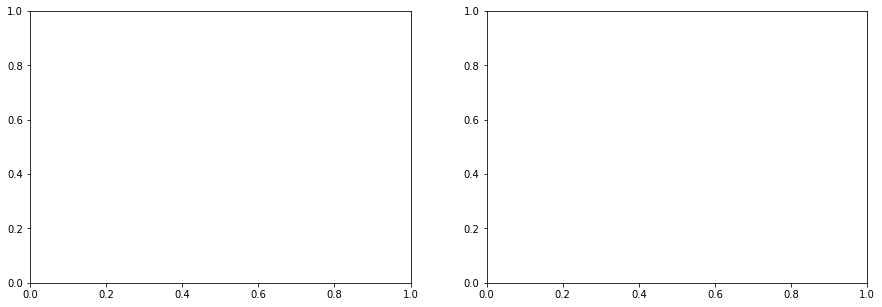

In [50]:
plot_model_history(history)

In [ ]:
X_test = data_valid
y_test = data_valid_target

print "Accuracy on test data is: %0.2f"%accuracy(data_valid, data_valid_target, net)